In [1]:
import json
import numpy as np
import pandas as pd
import scipy.sparse
from superlink.superlink import SuperLink
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
sns.set_palette('husl')
%matplotlib inline

In [2]:
with open('../data/orifice.json', 'r') as j:
    inp = json.load(j)
    
superjunctions = pd.DataFrame(inp['superjunctions'])
superlinks = pd.DataFrame(inp['superlinks'])
junctions = pd.DataFrame(inp['junctions'])
links = pd.DataFrame(inp['links'])
orifices = pd.DataFrame(inp['orifices'])

In [3]:
H_bc = pd.read_csv('../data/boundary_stage.csv', index_col=0)
Q_in = pd.read_csv('../data/flow_input.csv', index_col=0)
t_range = H_bc.index.values
us = np.zeros(t_range.size).reshape(-1, 1)
us[500:] = 1

In [4]:
H_bc['6'] = H_bc['1']
H_bc.columns = [0, 1, 3, 4, 5, 6, 2]
H_bc = H_bc.sort_index(axis=1)

Q_in['6'] = Q_in['1']
Q_in.columns = [0, 1, 3, 4, 5, 6, 2]
Q_in = Q_in.sort_index(axis=1)

In [5]:
superlink = SuperLink(superlinks, superjunctions, links, junctions, orifices=orifices)    

In [6]:
# Create lists to store results
hs = []
Hs = []
Qs = []
ts = []
Q_ins = []
H_bcs = []

# Set initial time
t_prev = t_range[0]

# For each time step...
for i, t_next in enumerate(t_range[1:]):
    # Compute time difference between steps
    dt = t_next - t_prev
    # Get next stage boundary condition
    H_bc_next = H_bc.loc[t_next].values
    # Get net flow input
    Q_in_next = Q_in.loc[t_next].values
    # Get input signal
    u = us[i].reshape(1,1)
    # Run superlink algorithm
    superlink.step(H_bc=H_bc_next, Q_in=Q_in_next, u=u, dt=dt)
    # Store previous timestamp
    t_prev = t_next
    # Store results
    ts.append(t_next)
    hs.append(np.copy(superlink._h_Ik))
    Hs.append(superlink.H_j)
    Qs.append((superlink._Q_uk + superlink._Q_dk) / 2)
    Q_ins.append(Q_in_next)
    H_bcs.append(H_bc_next)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [7]:
Q = np.vstack(Qs)
H = np.vstack(Hs)
Q_in = np.vstack(Q_ins)
H_bc = np.vstack(H_bcs)
ts = np.asarray(ts)

In [8]:
sns.set_palette('husl', 7)

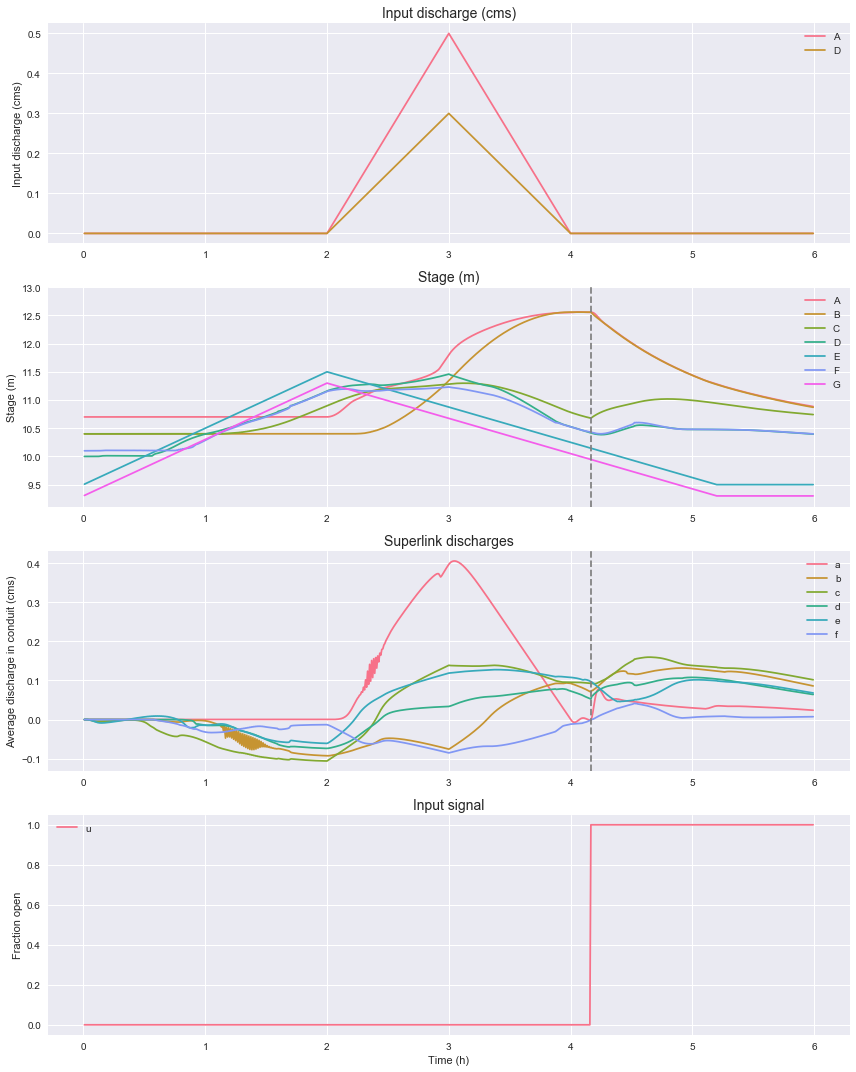

In [9]:
fig, ax = plt.subplots(4, figsize=(12, 15))
ax[0].plot(ts / 3600, Q_in[:,0], label='A')
ax[0].plot(ts / 3600, Q_in[:,3], label='D')
ax[0].set_title('Input discharge (cms)', size=14)
ax[0].set_ylabel('Input discharge (cms)')
ax[0].legend()
ax[1].plot(ts / 3600, H[:,0], label='A')
ax[1].plot(ts / 3600, H[:,1], label='B')
ax[1].plot(ts / 3600, H[:,2], label='C')
ax[1].plot(ts / 3600, H[:,3], label='D')
ax[1].plot(ts / 3600, H[:,4], label='E')
ax[1].plot(ts / 3600, H[:,5], label='F')
ax[1].plot(ts / 3600, H[:,6], label='G')
ax[1].set_ylim(9.1, 13)
ax[1].axvline(t_range[500] / 3600, c='0.5', linestyle='--')
ax[1].set_title('Stage (m)', size=14)
ax[1].set_ylabel('Stage (m)')
ax[1].legend()
ax[2].plot(ts / 3600, Q[:,0], label='a')
ax[2].plot(ts / 3600, Q[:,1], label='b')
ax[2].plot(ts / 3600, Q[:,2], label='c')
ax[2].plot(ts / 3600, Q[:,3], label='d')
ax[2].plot(ts / 3600, Q[:,4], label='e')
ax[2].plot(ts / 3600, Q[:,5], label='f')
ax[2].axvline(t_range[500] / 3600, c='0.5', linestyle='--')
ax[2].set_title('Superlink discharges', size=14)
ax[2].set_ylabel('Average discharge in conduit (cms)')
ax[2].legend()
ax[3].plot(ts / 3600, us[1:], label='u')
ax[3].set_title('Input signal', size=14)
ax[3].set_xlabel('Time (h)')
ax[3].set_ylabel('Fraction open')
ax[3].legend()
plt.tight_layout()